### ch06_GAN_mnist

In [10]:
# 建置並編譯鑑別器(discriminator)
from tensorflow.keras import layers, models
from tensorflow import keras

img_rows = 28
img_cols = 28
channels = 1

d_inputs = keras.Input(shape=(img_rows,img_cols), name="d_inputs")
d = layers.Flatten(name="d_flatten")(d_inputs)
d = layers.Dense(units=512, name="d_dense_1")(d)
d = layers.LeakyReLU(alpha=0.2, name="d_relu_1")(d)
d = layers.Dense(units=256, name="d_dense_2")(d)
d = layers.LeakyReLU(alpha=0.2, name="d_relu_2")(d)
d_validity = layers.Dense(units=1, activation="sigmoid", name="d_validity")(d)

d_model = models.Model(d_inputs, d_validity, name="model_discriminator")
d_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
d_model.summary()

d_model.trainable = False

Model: "model_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_inputs (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
d_flatten (Flatten)          (None, 784)               0         
_________________________________________________________________
d_dense_1 (Dense)            (None, 512)               401920    
_________________________________________________________________
d_relu_1 (LeakyReLU)         (None, 512)               0         
_________________________________________________________________
d_dense_2 (Dense)            (None, 256)               131328    
_________________________________________________________________
d_relu_2 (LeakyReLU)         (None, 256)               0         
_________________________________________________________________
d_validity (Dense)           (None, 1)         

In [17]:
g_model = models.Sequential()
g_model.add(layers.Dense(units=128, name="g_dense_1"))
g_model.add(layers.LeakyReLU(alpha=0.2, name="g_relu_1"))
g_model.add(layers.Dense(units=256, name="g_dense_2"))
g_model.add(layers.LeakyReLU(alpha=0.2, name="g_relu_2"))
g_model.add(layers.Dense(units=512, name="g_dense_3"))
g_model.add(layers.LeakyReLU(alpha=0.2, name="g_relu_3"))
g_model.add(layers.BatchNormalization(name="g_normal"))
g_model.add(layers.Dense(units=(img_rows*img_cols), activation="tanh", name="g_dense_4"))
g_model.add(layers.Reshape(target_shape=(img_rows,img_cols), name="g_validity"))

# 輸入生成器生成之圖片到鑑別器中
z = keras.Input(shape=(100,))
img = g_model(z)
validity = d_model(img)

#透過訓練使生成器生成的圖片足以混淆鑑別器的判斷
c_model = models.Model(z, validity)
c_model.compile(loss='binary_crossentropy', optimizer="adam")
c_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28)            581776    
_________________________________________________________________
model_discriminator (Model)  (None, 1)                 533505    
Total params: 1,115,281
Trainable params: 580,752
Non-trainable params: 534,529
_________________________________________________________________


In [23]:
import numpy as np
from tensorflow.keras.datasets import mnist
# 讀取mnist資料庫
(x_train, _), (_, _) = mnist.load_data()

x_train = x_train[:6000]
# 調整目標樣本型態，訓練集資料
x_train = x_train / 127.5 - 1.
#x_train = np.expand_dims(x_train, axis=3)

batch_size = 128

# 設置生成對抗性事實(Adversarial ground truths)參數
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))


In [25]:
for i in range(len(x_train)//batch_size):
    imgs = x_train[i*batch_size:(i+1)*batch_size]
    
    noise = np.random.normal(0, 1, (batch_size, 100))
    # 生成批次大小數量的圖片
    gen_imgs = g_model.predict(noise)

    # 訓練鑑別器
    d_loss_real = d_model.train_on_batch(imgs, valid)
    d_loss_fake = d_model.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, 100))
    
    # 訓練生成器
    g_loss = c_model.train_on_batch(noise, valid)
    
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

0 [D loss: 0.227261, acc.: 100.00%] [G loss: 0.427187]
1 [D loss: 0.130242, acc.: 100.00%] [G loss: 0.448771]
2 [D loss: 0.083774, acc.: 100.00%] [G loss: 0.486653]
3 [D loss: 0.062856, acc.: 100.00%] [G loss: 0.519980]
4 [D loss: 0.046663, acc.: 100.00%] [G loss: 0.550649]
5 [D loss: 0.033222, acc.: 100.00%] [G loss: 0.539564]
6 [D loss: 0.030694, acc.: 100.00%] [G loss: 0.707994]
7 [D loss: 0.055229, acc.: 100.00%] [G loss: 0.766304]
8 [D loss: 0.054027, acc.: 100.00%] [G loss: 0.779538]
9 [D loss: 0.030094, acc.: 100.00%] [G loss: 1.009564]
10 [D loss: 0.013447, acc.: 100.00%] [G loss: 1.221843]
11 [D loss: 0.027757, acc.: 100.00%] [G loss: 1.123853]
12 [D loss: 0.044351, acc.: 99.61%] [G loss: 0.976547]
13 [D loss: 0.052555, acc.: 100.00%] [G loss: 1.052782]
14 [D loss: 0.022306, acc.: 100.00%] [G loss: 1.077788]
15 [D loss: 0.262606, acc.: 89.45%] [G loss: 0.806590]
16 [D loss: 0.631722, acc.: 61.72%] [G loss: 0.579529]
17 [D loss: 0.310540, acc.: 82.42%] [G loss: 0.723996]
18 [D 

In [26]:
a = d_model.predict(x_train[12:13])
print(a.shape)

(1, 1)


In [27]:
a

array([[1.]], dtype=float32)

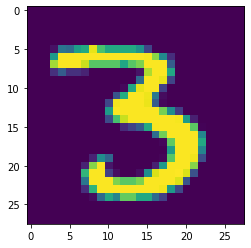

In [30]:
import matplotlib.pyplot as plt
plt.imshow(x_train[12])
plt.show()

In [ ]:
def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        #訓練過程中圖像儲存
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()